In [1]:
%pylab inline
import os
import keras
import metrics
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

# run the code under DEC-keras
## git clone https://github.com/XifengGuo/DEC-keras
## cd DEC-keras

# download the data from: https://datahack.analyticsvidhya.com/contest/practice-problem-identify-the-digits/

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
seed = 410  # I miss him, miss him so much
rng = np.random.RandomState(seed)

In [3]:
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, 'data', 'minist')

In [4]:
# I moved the downloaded data into /minist
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


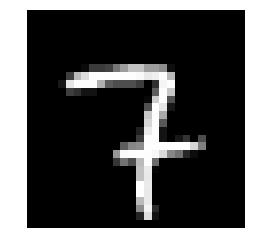

In [16]:
# randomly chose the digit to print out
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'train', img_name)

img = imread(filepath, flatten=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [5]:
# store the images into numpy array
def image2array(image_folder_path, filename_lst):
    temp = []
    for img_name in filename_lst.filename:
        image_path = os.path.join(image_folder_path, img_name)
        img = imread(image_path, flatten=True)
        img = img.astype('float32')
        temp.append(img)

    data_x = np.stack(temp)

    data_x /= 255.0
    data_x = data_x.reshape(-1, 784).astype('float32')
    
    return data_x

train_x = image2array(os.path.join(data_dir, 'train'), train)
test_x = image2array(os.path.join(data_dir, 'test'), test)

In [6]:
test_x[4:10]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [7]:
train_y = train.label.values
train_y[4:10]

array([3, 9, 4, 9, 3, 4])

In [8]:
# divide the training data into training and validation
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_y[:split_size], train_y[split_size:]

In [30]:
# Model 1 - Just use kmeans
km = KMeans(n_jobs=-1, n_clusters=10, n_init=20, random_state=410)  # n_init is the number of times to run
km.fit(train_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=410, tol=0.0001, verbose=0)

In [31]:
pred = km.predict(val_x)
normalized_mutual_info_score(val_y, pred)  # using normalized mutual info (NMI) for the evaluation, higher the better

0.49702986222381257

In [34]:
# Model 2 - autoencode to reduce dimension and extract useful info, then pass to kmeans
## input placeholder
input_img = Input(shape=(784,))

## "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

## "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784)(decoded)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_11 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                20010     
_________________________________________________________________
dense_13 (Dense)             (None, 2000)              22000     
_________________________________________________________________
dense_14 (Dense)             (None, 500)               1000500   
__________

In [36]:
# train the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')
train_history = autoencoder.fit(train_x, train_x, epochs=30, batch_size=2048, validation_data=(val_x, val_x))

Train on 34300 samples, validate on 14700 samples
Epoch 1/30
34300/34300 [==============================] - 24s - loss: 0.0341 - val_loss: 0.0273
Epoch 2/30
34300/34300 [==============================] - 25s - loss: 0.0255 - val_loss: 0.0244
Epoch 3/30
34300/34300 [==============================] - 29s - loss: 0.0236 - val_loss: 0.0234
Epoch 4/30
34300/34300 [==============================] - 30s - loss: 0.0229 - val_loss: 0.0231
Epoch 5/30
34300/34300 [==============================] - 24s - loss: 0.0226 - val_loss: 0.0228
Epoch 6/30
34300/34300 [==============================] - 26s - loss: 0.0224 - val_loss: 0.0226
Epoch 7/30
34300/34300 [==============================] - 22s - loss: 0.0221 - val_loss: 0.0224
Epoch 8/30
34300/34300 [==============================] - 22s - loss: 0.0219 - val_loss: 0.0222
Epoch 9/30
34300/34300 [==============================] - 25s - loss: 0.0217 - val_loss: 0.0220
Epoch 10/30
34300/34300 [==============================] - 27s - loss: 0.0214 - val_lo

In [ ]:
##  this model maps an input to its encoded representation
### this part takes a while
encoder = Model(input_img, encoded)

In [ ]:
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(val_x)

In [ ]:
km.fit(pred_auto_train)
pred = km.predict(pred_auto)

normalized_mutual_info_score(val_y, pred)

In [9]:
# You need to copy the code from DEC-keras: https://github.com/XifengGuo/DEC-keras/blob/master/DEC.py
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Author:
    Xifeng Guo. 2017.1.30
"""


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, y_pred), 5)
                    nmi = np.round(metrics.nmi(y, y_pred), 5)
                    ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred


In [10]:
# Model 3 - DEC Keras

# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 2048
maxiter = 7
tol = 0.001
save_dir = 'DEC_results'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 30
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  


# prepare the DEC model
dec = DEC(dims=[train_x.shape[-1], 500, 500, 2000, 10], n_clusters=10, init=init)

dec.pretrain(x=train_x, y=train_y, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)

...Pretraining...
Epoch 1/30
34300/34300 [==============================] - 27s - loss: 0.1101    
Epoch 2/30
34300/34300 [==============================] - 20s - loss: 0.0723    
Epoch 3/30
34300/34300 [==============================] - 27s - loss: 0.0647    
Epoch 4/30
34300/34300 [==============================] - 32s - loss: 0.0638    
Epoch 5/30
34300/34300 [==============================] - 24s - loss: 0.0635    
Epoch 6/30
34300/34300 [==============================] - 18s - loss: 0.0633    
Epoch 7/30
34300/34300 [==============================] - 27s - loss: 0.0606    
Epoch 8/30
34300/34300 [==============================] - 18s - loss: 0.0568    
Epoch 9/30
34300/34300 [==============================] - 18s - loss: 0.0549    
Epoch 10/30
34300/34300 [==============================] - 26s - loss: 0.0513    
Epoch 11/30
34300/34300 [==============================] - 17s - loss: 0.0483    
Epoch 12/30
34300/34300 [==============================] - 17s - loss: 0.0459    
Epoch 1

In [11]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110
Trainable params: 1,665,110
Non-trainable params: 0
_________________________________________________________________


In [12]:
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [14]:
y_pred = dec.fit(train_x, y=train_y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                 update_interval=update_interval, save_dir=save_dir)

('Update interval', 200)
('Save interval', 80)
Initializing cluster centers with k-means.
('Iter 0: acc = 0.61656, nmi = 0.55830, ari = 0.45864', ' ; loss=', 0)
('saving model to:', 'DEC_results/DEC_model_0.h5')
('saving model to:', 'DEC_results/DEC_model_final.h5')


In [17]:
pred_val = dec.predict(val_x)
normalized_mutual_info_score(val_y, pred_val)

0.54670800216786986